Librerias necesarias

In [87]:
import json
import gzip
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import matplotlib.pyplot as plt # Visualización
from wordcloud import WordCloud # Exploración

import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV # Modelado
from sklearn.feature_extraction.text import TfidfVectorizer # Modelado
from sklearn.linear_model import LogisticRegression # Modelado
from sklearn.metrics import accuracy_score # Metricas
from sklearn.ensemble import GradientBoostingClassifier # Modelado

# **1. Descarga y exploración de datos**

In [88]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Luxury_Beauty_5.json.gz

--2024-03-27 13:04:21--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Luxury_Beauty_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356868 (7.0M) [application/x-gzip]
Saving to: ‘Luxury_Beauty_5.json.gz.1’

Luxury_Beauty_5.jso 100%[===================>]   7.02M  12.6MB/s    in 0.6s    

2024-03-27 13:04:22 (12.6 MB/s) - ‘Luxury_Beauty_5.json.gz.1’ saved [7356868/7356868]



In [89]:
# load the meta data
nombre_archivo = 'Luxury_Beauty_5.json.gz'

data = []
with gzip.open(nombre_archivo, 'rb') as f:
  for l in f:
    data.append(json.loads(l.strip()))

In [90]:
# Guardamos nuestros datos en un dataframe para poder trabajar con ellos.

df = pd.DataFrame.from_dict(data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


In [91]:
print(df.shape)
print(df.info())

(34278, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34278 entries, 0 to 34277
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         34278 non-null  float64
 1   verified        34278 non-null  bool   
 2   reviewTime      34278 non-null  object 
 3   reviewerID      34278 non-null  object 
 4   asin            34278 non-null  object 
 5   style           16841 non-null  object 
 6   reviewerName    34278 non-null  object 
 7   reviewText      34265 non-null  object 
 8   summary         34263 non-null  object 
 9   unixReviewTime  34278 non-null  int64  
 10  vote            6532 non-null   object 
 11  image           617 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 2.9+ MB
None


El dataframe consta de 34.278 observaciones y 12 variables. Se trata de reviews de productos de belleza de lujo.  Tenemos la puntuación del producto, la review, la fecha de la review, el nombre del usuario, Id del usuario, imagen del producto, etc. De todas ellas me voy a quedar con overall y reviewText. También voy a eliminar las columnas que tenga NA en la columna review.

In [92]:
df= df[['reviewText', 'overall']].rename(columns={'reviewText': 'review', 'overall': 'score'})

Voy a eliminar las filas que tengan Na en la variable review.

In [93]:
df = df.dropna(subset=['review'])

Voy a representar la distribución de reviews por puntuación.

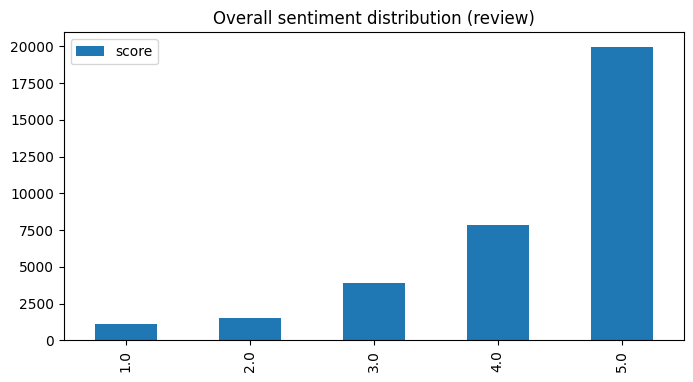

In [94]:
aux_df = pd.DataFrame(df['score'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Observamos que los datos están desbalanceados ya que más del 65% de los datos tienen una puntuación de 5. Voy a crear una función binaria en la que 1 significa que recomienda el producto y voy a considerar las puntuaciones de productos igual o superior a 4, y 0 en caso contrario.

In [95]:
def label_sentiment(row):
  if int(row['score']) < 4:
    return 0
  else:
    return 1

In [96]:
df['sentiment_label'] = df.apply(lambda row:label_sentiment(row), axis = 1)

In [97]:
df.head()

,review,score,sentiment_label
0,This handcream has a beautiful fragrance. It d...,5.0,1
1,"wonderful hand lotion, for seriously dry skin,...",5.0,1
2,"Best hand cream around. Silky, thick, soaks i...",5.0,1
3,Thanks!!,5.0,1
4,Great hand lotion. Soaks right in and leaves ...,5.0,1


Así quedaría la distribución de reviews de forma binaria.

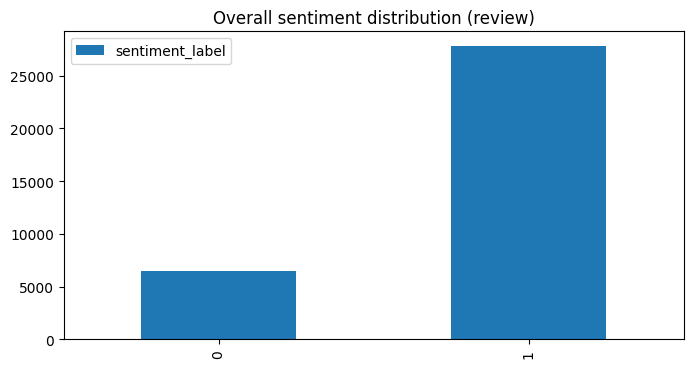

In [98]:
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Con una aproximación rápida, pasando a minúsculas y tokenizando por espacios, observamos que nuestro vocabulario está formado por 69.022 tokens.

In [99]:
splitted_reviews = df['review'].str.lower().str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary = Counter(words)
len(vocabulary)

69022

In [100]:

bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [101]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [102]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 12154),
 (('it', 'is'), 9552),
 (('is', 'a'), 9453),
 (('this', 'is'), 8860),
 (('in', 'the'), 8328),
 (('of', 'the'), 8321),
 (('my', 'skin'), 7535),
 (('and', 'i'), 6492),
 (('on', 'my'), 5831),
 (('and', 'it'), 5537)]

In [103]:
trigrams_freq_.most_common(10)

[(('this', 'is', 'a'), 3390),
 (('a', 'lot', 'of'), 1911),
 (('it', 'is', 'a'), 1465),
 (('it', 'has', 'a'), 1393),
 (('as', 'well', 'as'), 1157),
 (('i', 'have', 'been'), 1109),
 (('goes', 'a', 'long'), 1039),
 (('i', 'love', 'the'), 970),
 (('this', 'is', 'the'), 967),
 (('i', 'have', 'used'), 937)]

Observamos que hay que hacer una limpieza de las stopwords ya que los bigramas y trigramas más frecuentes están formados prácticamente por palabras que no nos dan información sobre las reviews ya que se tratan de preposiciones, pronombres, artículos...

Si hacemos una nube de palabras observamos que palabras como *product* y *skin* tienen gran relevancia.

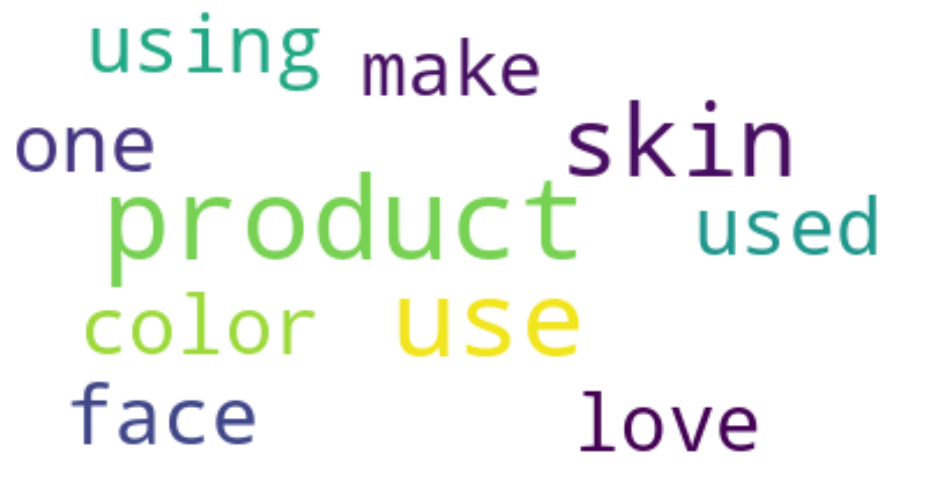

In [104]:


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=10, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_word_cloud(words)

# **2. Preprocesamiento**



En primer lugar, vamos a pasar todas las letras a minúsculas, eliminar carácteres extraños y separar el texto en frases. Voy a calcular una lista de stopwords en inglés y vamos a eliminar todas aquellas que se encuentren en esta lista. Por último, vamos a rehacer la frase.

In [105]:
nltk.download('stopwords')
nltk.download('punkt')

def text_normalizer(text, lemmatize=False):
    processed_text = []

    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Tokenizar el texto en frases
    sentences = sent_tokenize(text)

    # Lista de stop words en inglés
    sw_list = set(nltk.corpus.stopwords.words('english'))

    # Para cada frase
    for sentence in sentences:
        words = word_tokenize(sentence)
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list:
                processed_text.append(word)
        processed_text.append(' ')

    return ' '.join(processed_text).strip()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
review_normalized = df['review'].apply(lambda x: text_normalizer(x, lemmatize=True))

In [108]:
df['review_normalized'] = review_normalized

In [109]:
print('Review original: {}'.format(df['review'].values[0]))
print('Review normalizada: {}'.format(df['review_normalized'].values[0]))

Review original: This handcream has a beautiful fragrance. It doesnt stay on or protect your hands through washing.  This size is quite small.
Review normalizada: handcream beautiful fragrance   doesnt stay protect hands washing   size quite small


In [110]:
df = df[['review_normalized', 'sentiment_label']]

In [111]:
df.head()

,review_normalized,sentiment_label
0,handcream beautiful fragrance doesnt stay pr...,1
1,wonderful hand lotion seriously dry skin stays...,1
2,best hand cream around silky thick soaks way...,1
3,thanks,1
4,great hand lotion soaks right leaves skin su...,1


# **3. Modelado**

Creamos los conjuntos de entrenamiento(75% del total) y test(25%).

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review_normalized'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [113]:
X_train.iloc[:10]

30439    'm pleased   yes people complained packaging h...
28472    lavender shade concealing crayon intended neut...
22728    fun unique bright pink   color thinner darker ...
12579    color n't bright nevertheless still like green...
24508    gorgeous   normally top liquid foundation loos...
8340     would nice product fragrance-free   sensitive ...
28739                                                   ok
6145     stuff amazing   thinning spots covers binds ha...
6214     made father 's hair look great bad ca n't stay...
8543     works well covering red scar face   required l...
Name: review_normalized, dtype: object

In [114]:
y_train.iloc[:10]

30439    1
28472    1
22728    1
12579    1
24508    1
8340     0
28739    1
6145     1
6214     1
8543     1
Name: sentiment_label, dtype: int64

In [115]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

In [116]:
print(list(cv.vocabulary_.items())[:20])

[('pleased', 1600), ('yes', 2489), ('people', 1556), ('packaging', 1513), ('happen', 957), ('like', 1200), ('small', 1983), ('sizes', 1968), ('tough', 2274), ('handle', 953), ('problem', 1658), ('although', 94), ('traveling', 2283), ('right', 1808), ('choice', 376), ('next', 1406), ('results', 1794), ('past', 1536), ('half', 951), ('mark', 1285)]


In [117]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Voy a hacer una regresión logística. Utilizando validación cruzada, voy a obtener el valor de C para el que obtenemos un valor de accuracy mejor.

In [118]:
# Diferentes parámetros de C
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

# Inicializar el clasificador de regresión logística
lr = LogisticRegression(solver='lbfgs', max_iter=500)

# Inicializar GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV
grid_search.fit(X_train_, y_train)

# Obtener el mejor valor de C
best_C = grid_search.best_params_['C']
print("Mejor valor de C:", best_C)

Mejor valor de C: 5


Ahora, voy a entrenar mis datos en  otro modelo de regresión logística con este valor de C.

In [120]:
# Inicializar un nuevo clasificador de regresión logística con el mejor valor de C
best_lr = LogisticRegression(C=best_C, solver='lbfgs', max_iter=500)

# Entrenar el modelo con los datos de entrenamiento
best_lr.fit(X_train_, y_train)

# Predecir las etiquetas en los datos de prueba
y_pred = best_lr.predict(X_test_)

# Calcular el accuracy del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy del mejor modelo con C={}: {:.4f}".format(best_C, accuracy))

Accuracy del mejor modelo con C=5: 0.8812


Ahora voy a comparar mi modelo logístico con un modelo de Gradient Boosting, calculando el número de estimadores óptimos utilizando validación cruzada.

In [121]:
# Diferentes valores de estimadores
param_grid = {'n_estimators': [10, 20, 50, 100]}

# Inicializar el clasificador de Gradient Boosting
gb_clf = GradientBoostingClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV
grid_search.fit(X_train_, y_train)

# Obtener el mejor número de estimadores
best_n_estimators = grid_search.best_params_['n_estimators']
print("Mejor número de estimadores:", best_n_estimators)

Mejor número de estimadores: 100


In [122]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en los datos de prueba
accuracy = best_model.score(X_test_, y_test)
print("Accuracy del modelo con {} estimadores: {:.4f}".format (best_n_estimators,accuracy))

Accuracy del modelo con 100 estimadores: 0.8409


Observamos que ambos modelos tienen un accuracy similar, ligeramente mejor el modelo de regresión logística. Al ser métricas muy parecidas, para decidirnos por uno u otro, tendríamos que tener en cuenta más métricas de evaluación como recall o F1-score. Otro punto a tener en cuenta es que los modelos de regresión logistica son más rápidos de entrenar y predecir que los modelos de Gradient Boosting.